In [2]:
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.backend.pypdfium2_backend import PyPdfiumDocumentBackend
from docling.datamodel.base_models import InputFormat
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.chunking import HybridChunker

from pydantic.v1 import BaseModel

from transformers import AutoTokenizer
from sentence_transformers import CrossEncoder

import os
import json

from pprint import PrettyPrinter
import pandas as pd
import time

/Users/yoyo/opt/anaconda3/envs/cathay_llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# document local path or URL
doc = "./test_doc/test_textMore.pdf" # simple text with a image and table
doc1 = "./test_doc/吉美利101利率變動型美元終身壽險(定期給付型)DM.pdf" # complex text with simple aesthetic table
doc2 = "./test_doc/美利雙寶利率變動型美元終身保險 (定期給付型)DM.pdf" # complex text with complex aesthetic table
doc3 = "./test_doc/國泰金控出勤管理須知(修正後).pdf" # simple text with a simple table
doc4 = "./test_doc/國泰金控員工國內出差要點.pdf" # simple text with a simple table
doc5 = "./test_doc/國泰金控員工國外出差要點.pdf" # simple text with complex table
doc6 = "./test_doc/國泰金融控股股份有限公司資訊安全管理辦法.pdf" # simple text

# PyPdfium without EasyOCR
# --------------------
pipeline_options = PdfPipelineOptions()
pipeline_options.do_ocr = False
pipeline_options.do_table_structure = True
pipeline_options.table_structure_options.do_cell_matching = False
#pipeline_options.table_structure_options.do_cell_matching = True

#pipeline_options.table_structure_options.mode = 'accurate'

pipeline_options.images_scale = 2
pipeline_options.generate_page_images = True
pipeline_options.generate_picture_images = True

pypdfium_converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
        pipeline_options=pipeline_options, backend=PyPdfiumDocumentBackend
        )
    }
)

# print json
def show_json(data):
    if isinstance(data, str):
        obj = json.loads(data)
        print(json.dumps(obj, indent=4, ensure_ascii=False))
    elif isinstance(data, dict) or isinstance(data, list):
        print(json.dumps(data, indent=4, ensure_ascii=False))
    elif issubclass(type(data), BaseModel):
        print(json.dumps(data.dict(), indent=4, ensure_ascii=False))

# more readable output
pp = PrettyPrinter(
    indent=1,
    width=80,
    depth=3,
    sort_dicts=False,
)

# Do hybrid chunking to merge similar chunk
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-m3")

hybrid_chunker = HybridChunker(
    tokenizer=tokenizer,
    #max_tokens=1024,
    merge_peers=True  # optional, defaults to True
)

# TIME

In [4]:
# with single document
start_time = time.time()
single_conv_result = pypdfium_converter.convert(doc5)
docling_docs = single_conv_result.document
end_time = time.time() - start_time

print(f"pdf convert to dl_doc use: {end_time:.2f} sec")

start_time = time.time()
chunk_iter = hybrid_chunker.chunk(dl_doc=docling_docs)
chunks = list(chunk_iter)
end_time = time.time() - start_time

print(f"dl_doc convert to chunk use: {end_time:.2f} sec")


pdf convert to dl_doc use: 29.75 sec
dl_doc convert to chunk use: 0.10 sec


In [5]:
# with all document in test_doc
doc_source = [doc, doc1, doc2, doc3, doc4, doc5, doc6]

start_time = time.time()
conv_results = pypdfium_converter.convert_all(
    doc_source,
    raises_on_error=True,  # to let conversion run through all and examine results at the end
)
end_time = time.time() - start_time

print(f"all pdf convert to all dl_doc <generater> use: {end_time:.2f} sec")
print()

all_chunks = []
dl_doc_convertion_time = 0
hybrid_chunker_chunking_time = 0

start_time = time.time()
for i, conv_res in enumerate(conv_results):
    docling_docs = conv_res.document
    end_time = time.time() - start_time

    print(f"doc{i} pdf convert to dl_doc use: {end_time:.2f} sec")
    dl_doc_convertion_time += end_time

    start_time = time.time()
    chunk_iter = hybrid_chunker.chunk(dl_doc=docling_docs)
    chunks = list(chunk_iter)
    all_chunks += chunks
    end_time = time.time() - start_time

    print(f"doc{i} dl_doc convert to chunk use: {end_time:.2f} sec")
    print()
    hybrid_chunker_chunking_time += end_time

    start_time = time.time()

print("==== Summary ====")
print(f"total dl_doc convertion time: {dl_doc_convertion_time:.2f}")
print(f"total hybrid chunking time: {hybrid_chunker_chunking_time:.2f}")
print(f"total use time: {hybrid_chunker_chunking_time+dl_doc_convertion_time:.2f}")

all pdf convert to all dl_doc <generater> use: 0.00 sec

doc0 pdf convert to dl_doc use: 9.20 sec
doc0 dl_doc convert to chunk use: 0.14 sec

doc1 pdf convert to dl_doc use: 6.24 sec
doc1 dl_doc convert to chunk use: 0.04 sec

doc2 pdf convert to dl_doc use: 9.64 sec
doc2 dl_doc convert to chunk use: 0.10 sec

doc3 pdf convert to dl_doc use: 1.76 sec
doc3 dl_doc convert to chunk use: 0.02 sec

doc4 pdf convert to dl_doc use: 1.91 sec
doc4 dl_doc convert to chunk use: 0.02 sec

doc5 pdf convert to dl_doc use: 14.89 sec
doc5 dl_doc convert to chunk use: 0.09 sec

doc6 pdf convert to dl_doc use: 3.79 sec
doc6 dl_doc convert to chunk use: 0.13 sec

==== Summary ====
total dl_doc convertion time: 47.42
total hybrid chunking time: 0.53
total use time: 47.95


# about docling doc

In [6]:
print(type(conv_results))
print(type(single_conv_result))

<class 'generator'>
<class 'docling.datamodel.document.ConversionResult'>


In [7]:
"""for conv_res in conv_results:
    print(conv_res.status)
    #pp.pprint(vars(conv_res))"""

'for conv_res in conv_results:\n    print(conv_res.status)\n    #pp.pprint(vars(conv_res))'

{'input': InputDocument(file=PurePosixPath('國泰金控員工國外出差要點.pdf'), document_hash='63f9f22d1897f56b25cd8e40576ce69b7e9a4c33e721db4f6487f5510b64eb8c', valid=True, limits=DocumentLimits(max_num_pages=9223372036854775807, max_file_size=9223372036854775807, page_range=(1, 9223372036854775807)), format=<InputFormat.PDF: 'pdf'>, filesize=182787, page_count=6),
 'status': <ConversionStatus.SUCCESS: 'success'>,
 'errors': [],
 'pages': [Page(page_no=0, size=Size(width=595.5599975585938, height=842.0399780273438), cells=[Cell(id=1, text='國泰金融控股股份有限公司員工國外出差要點 ', bbox=BoundingBox(l=128.8400115966797, t=31.95001220703125, r=455.5252685546875, b=46.40972900390625, coord_origin=<CoordOrigin.TOPLEFT: 'TOPLEFT'>)), Cell(id=2, text=' ', bbox=BoundingBox(l=457.17999267578125, t=43.904052734375, r=465.1600036621094, b=43.91998291015625, coord_origin=<CoordOrigin.TOPLEFT: 'TOPLEFT'>)), Cell(id=3, text='940405 訂5 訂定', bbox=BoundingBox(l=476.52398681640625, t=59.052001953125, r=542.343994140625, b=69.1799926757
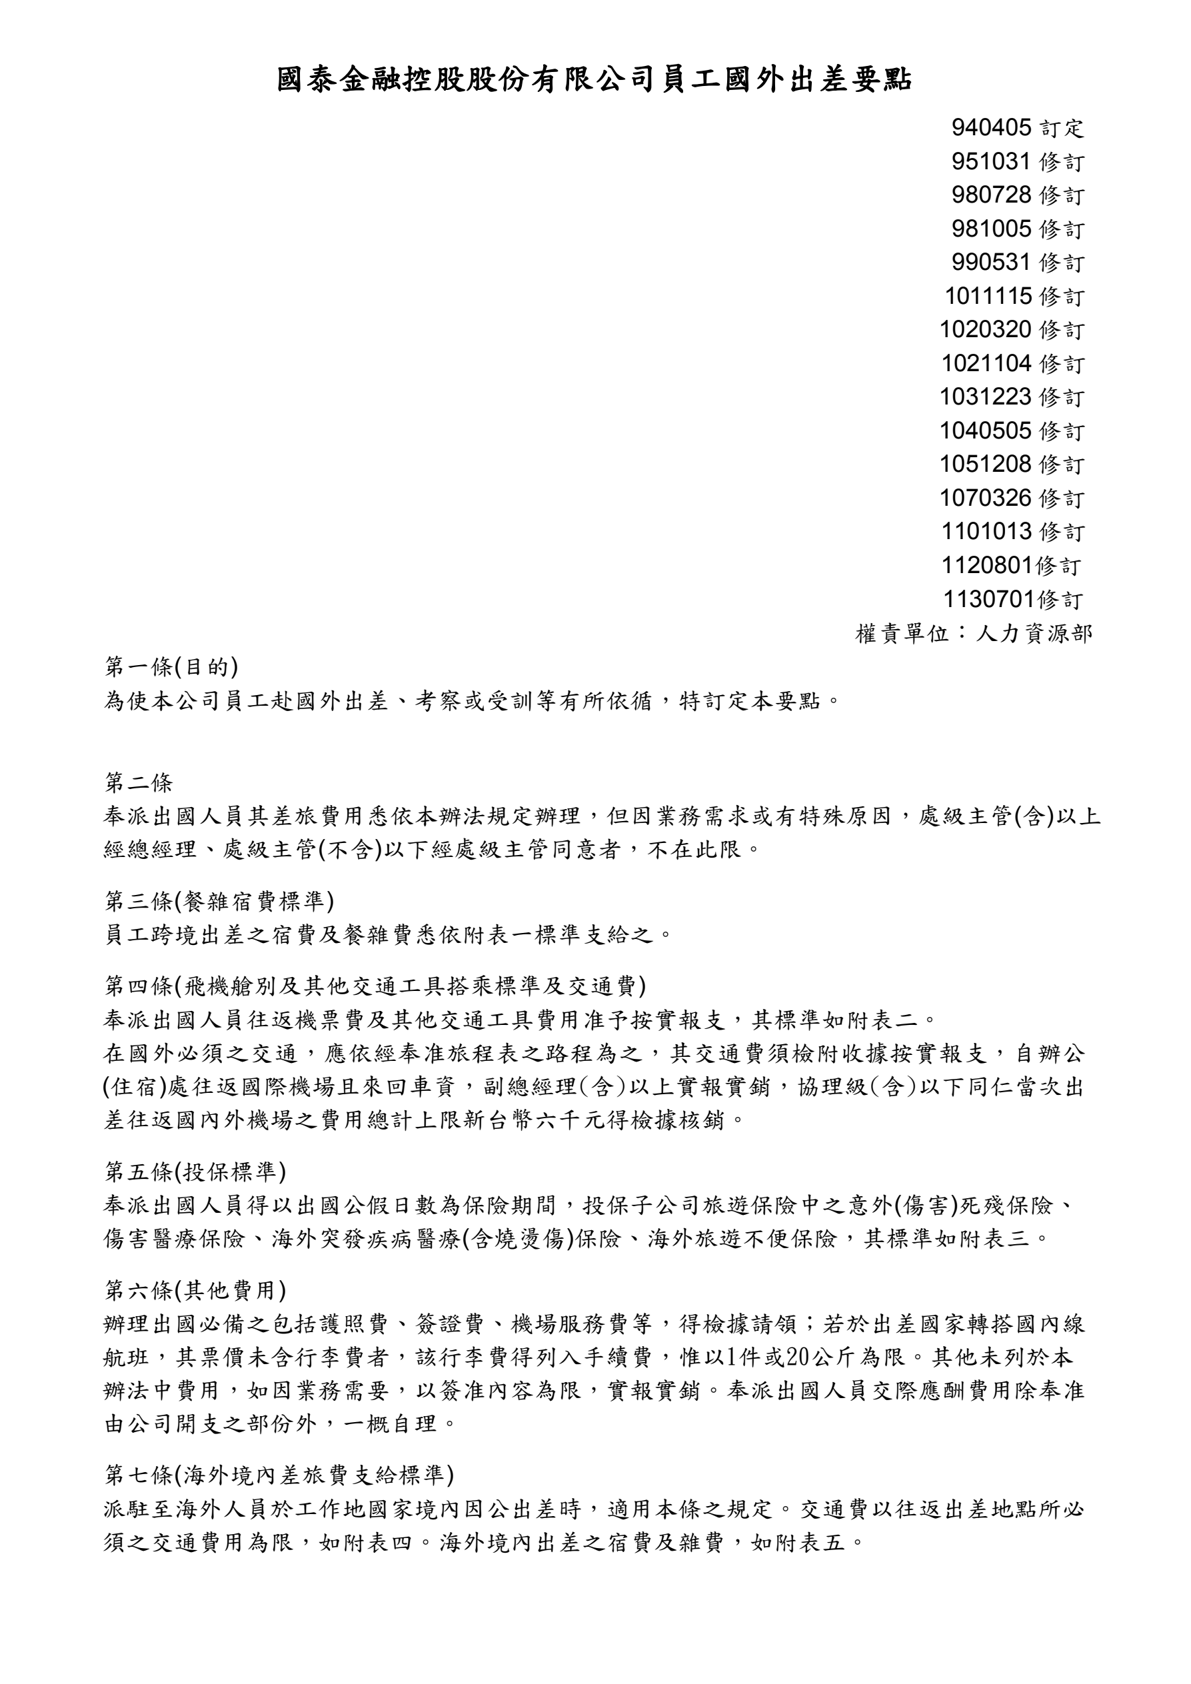
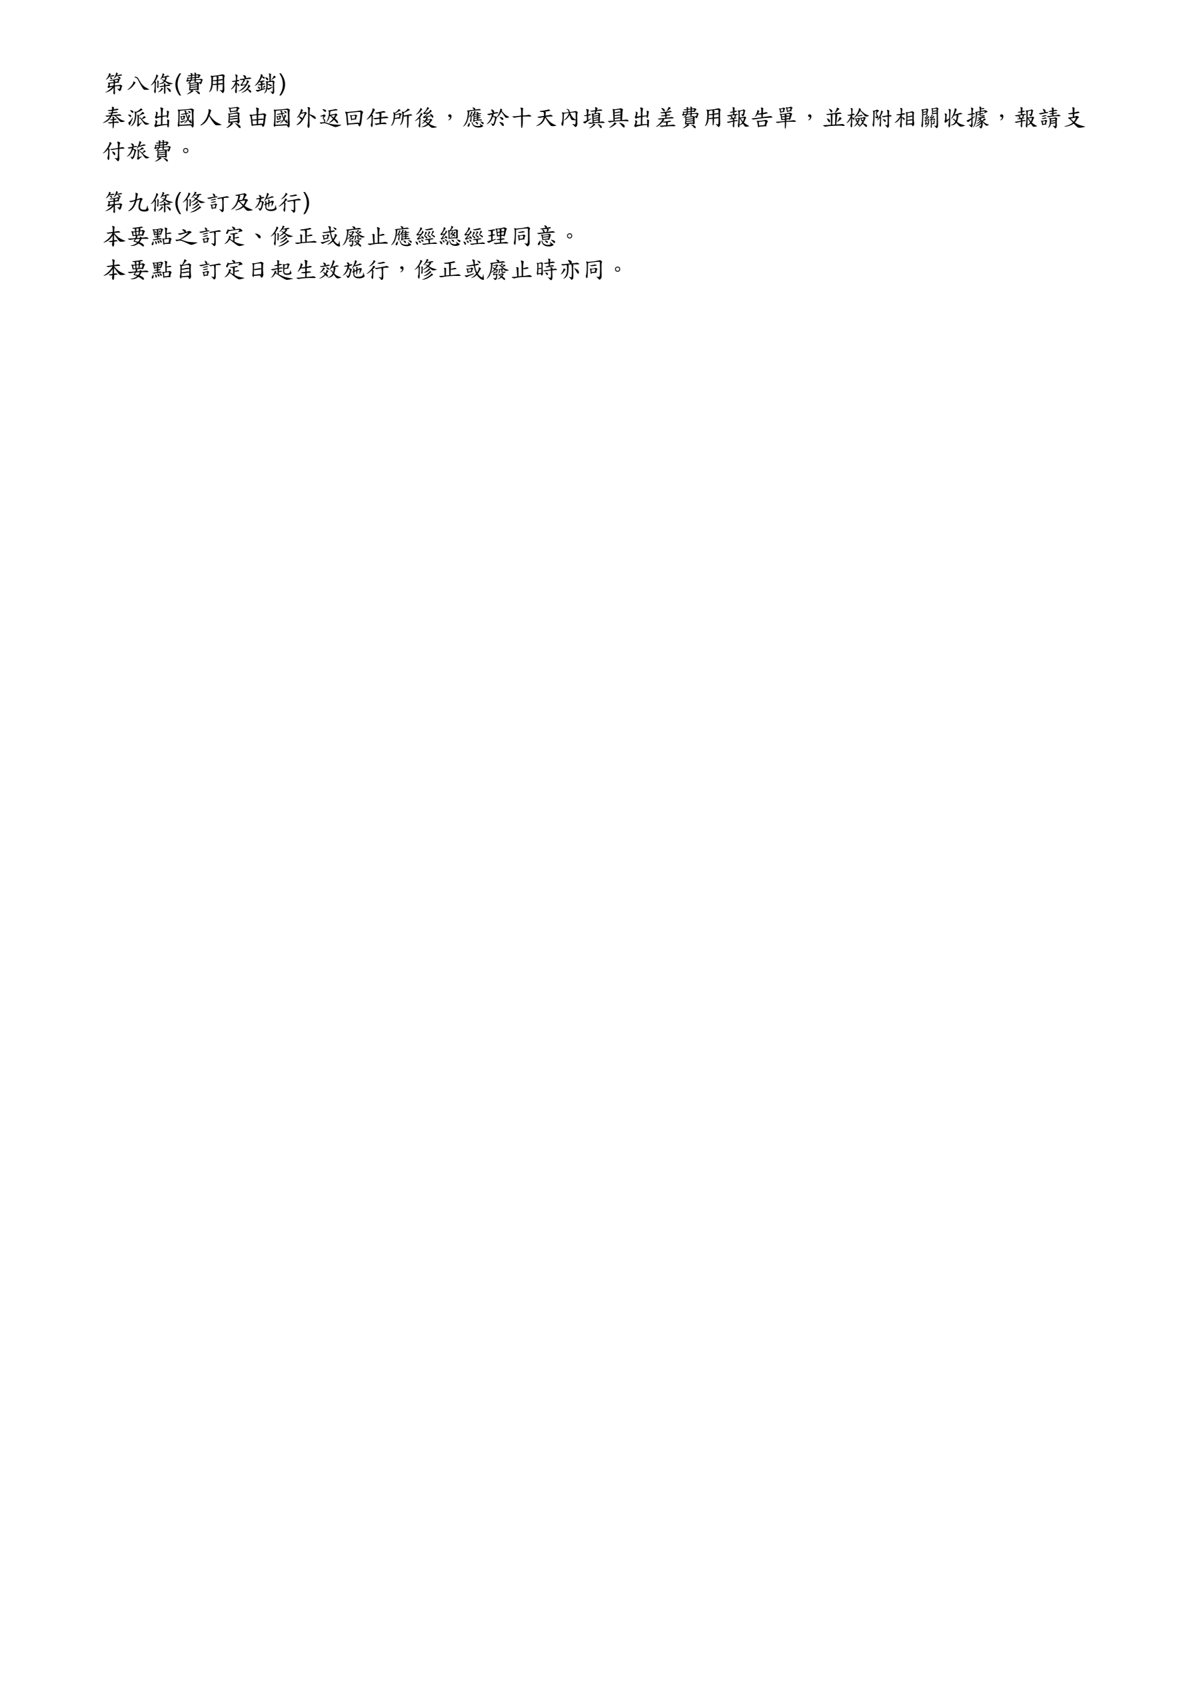
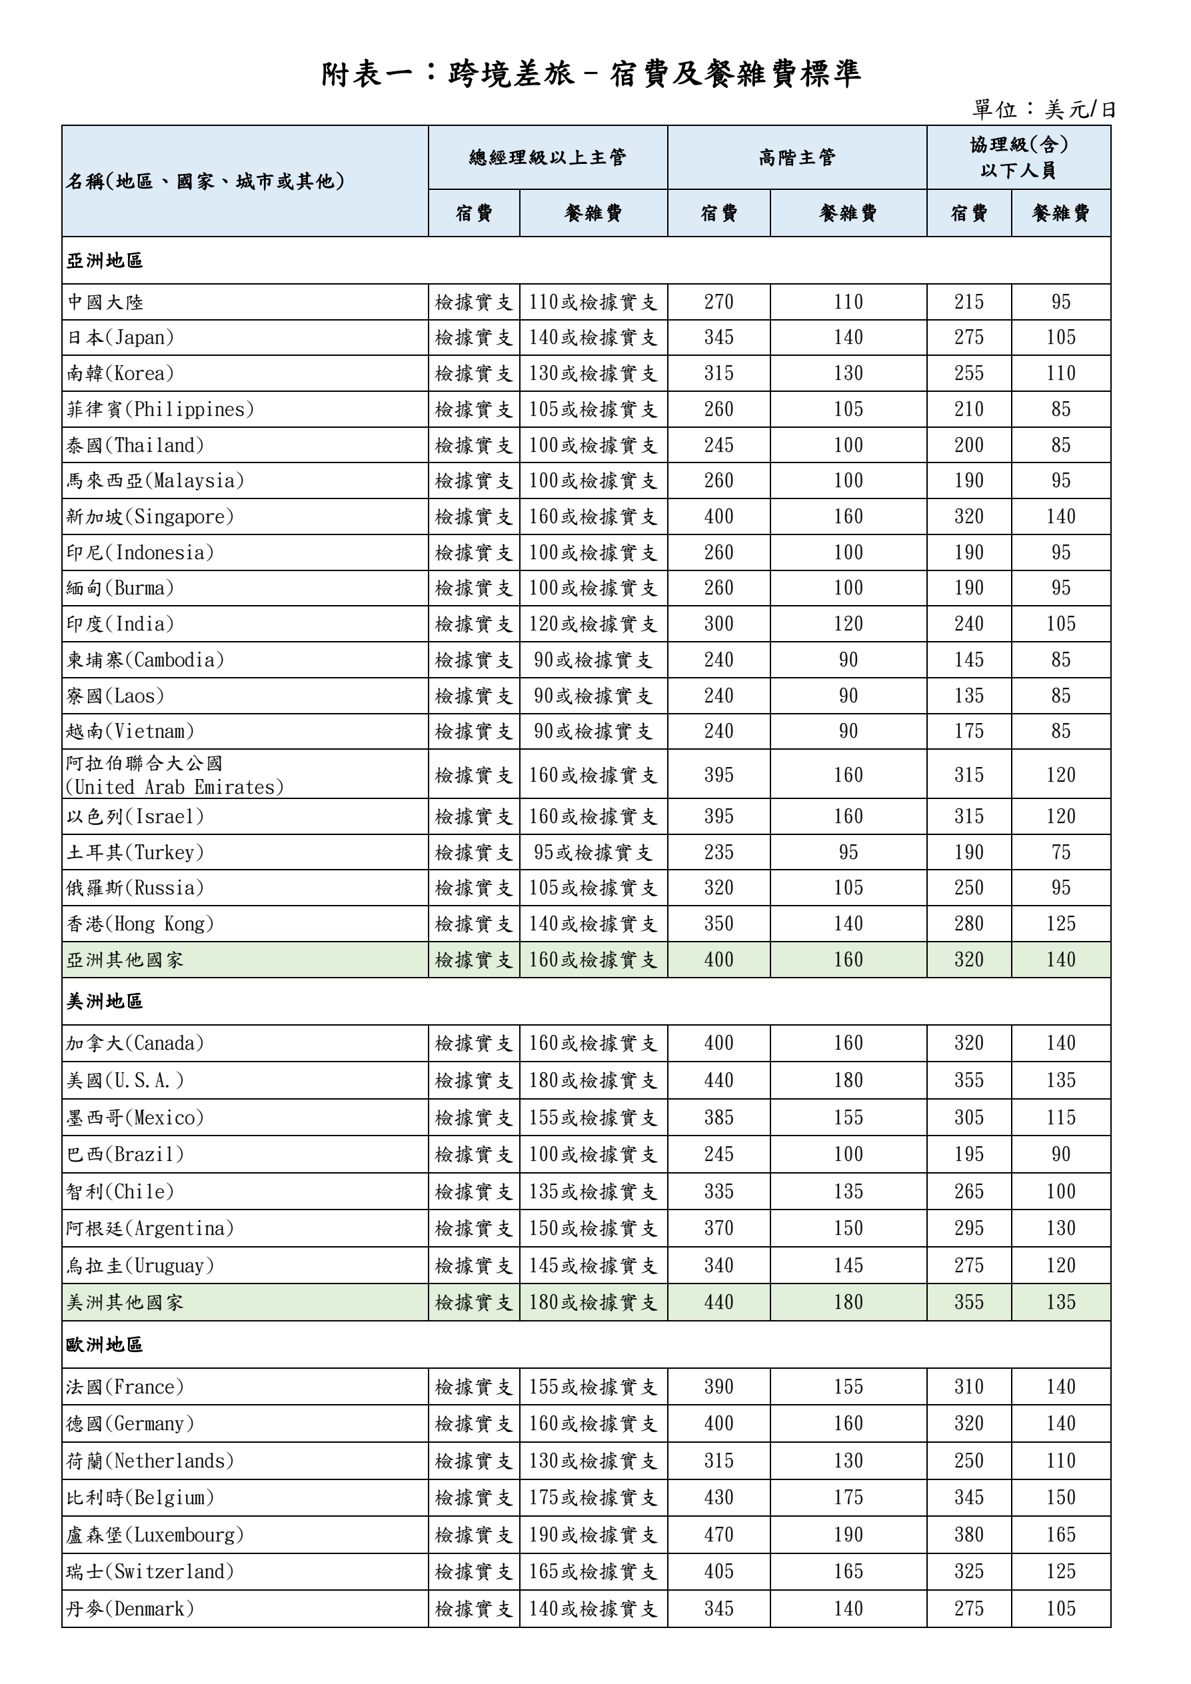
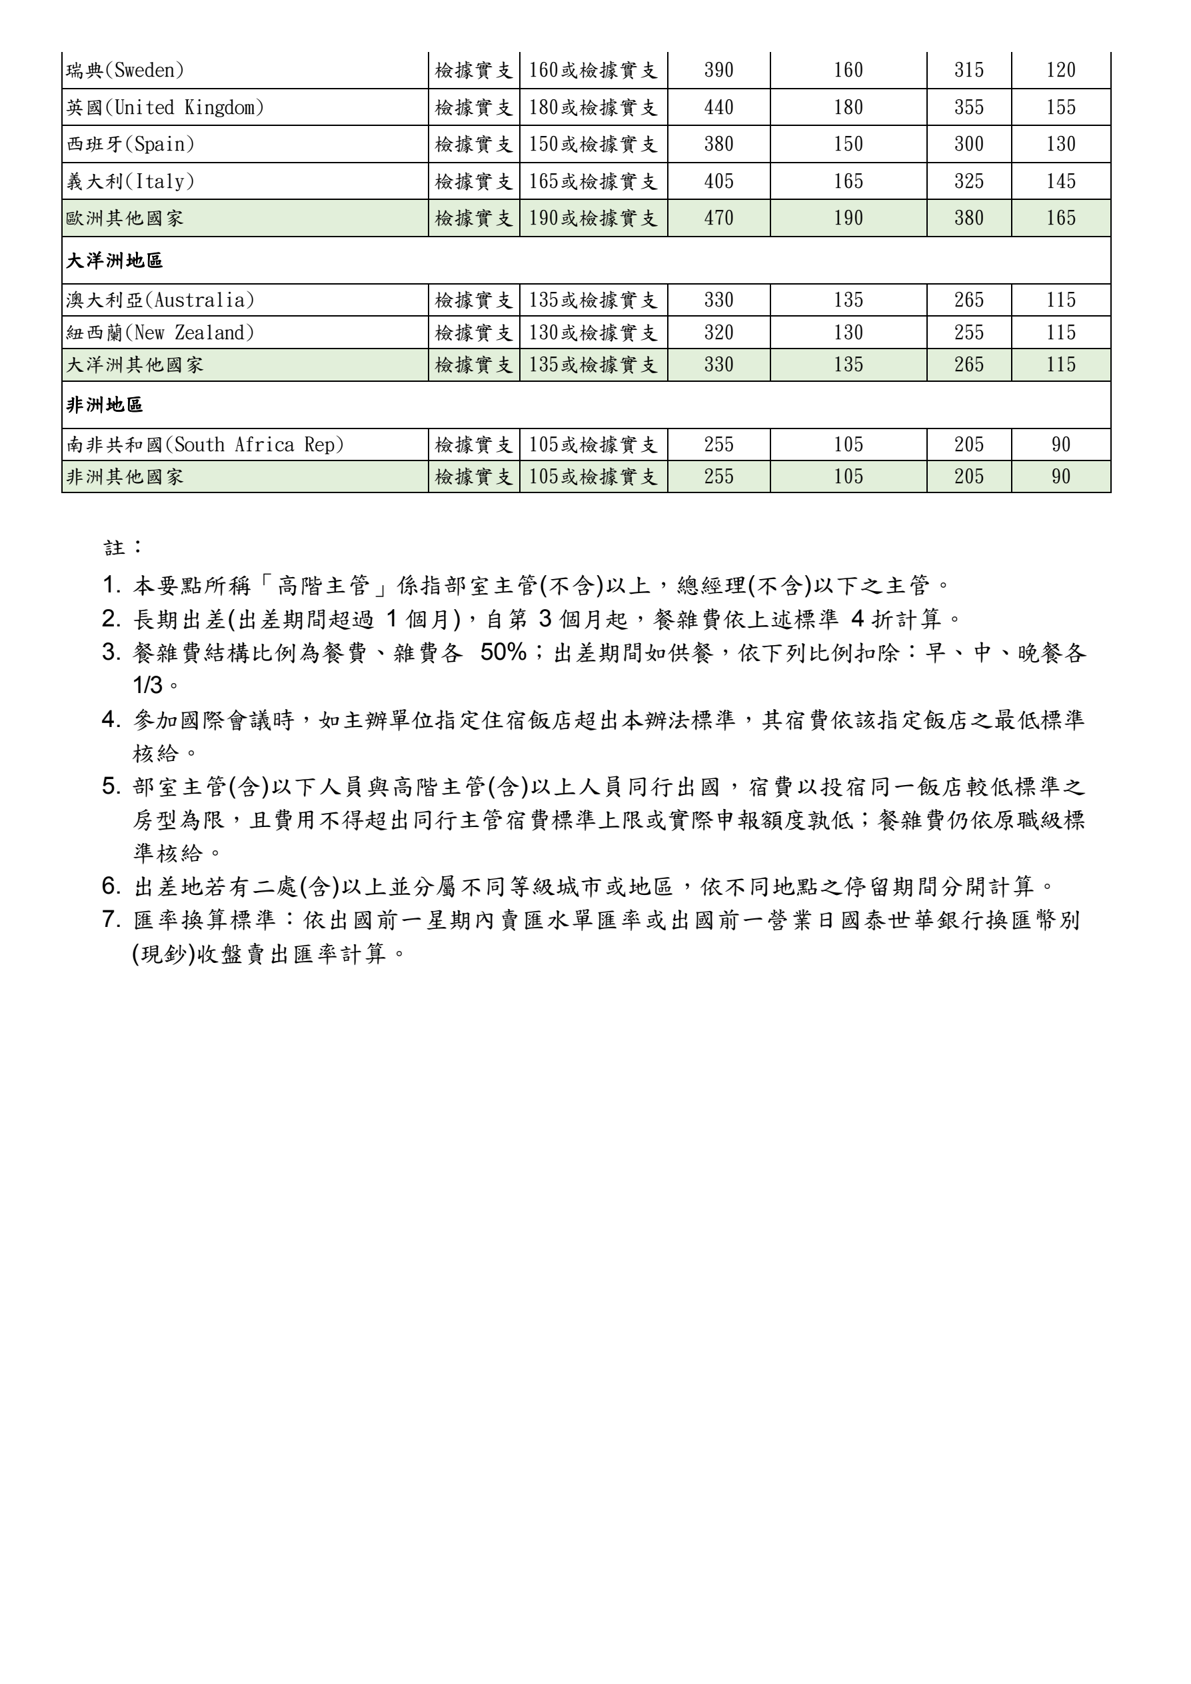
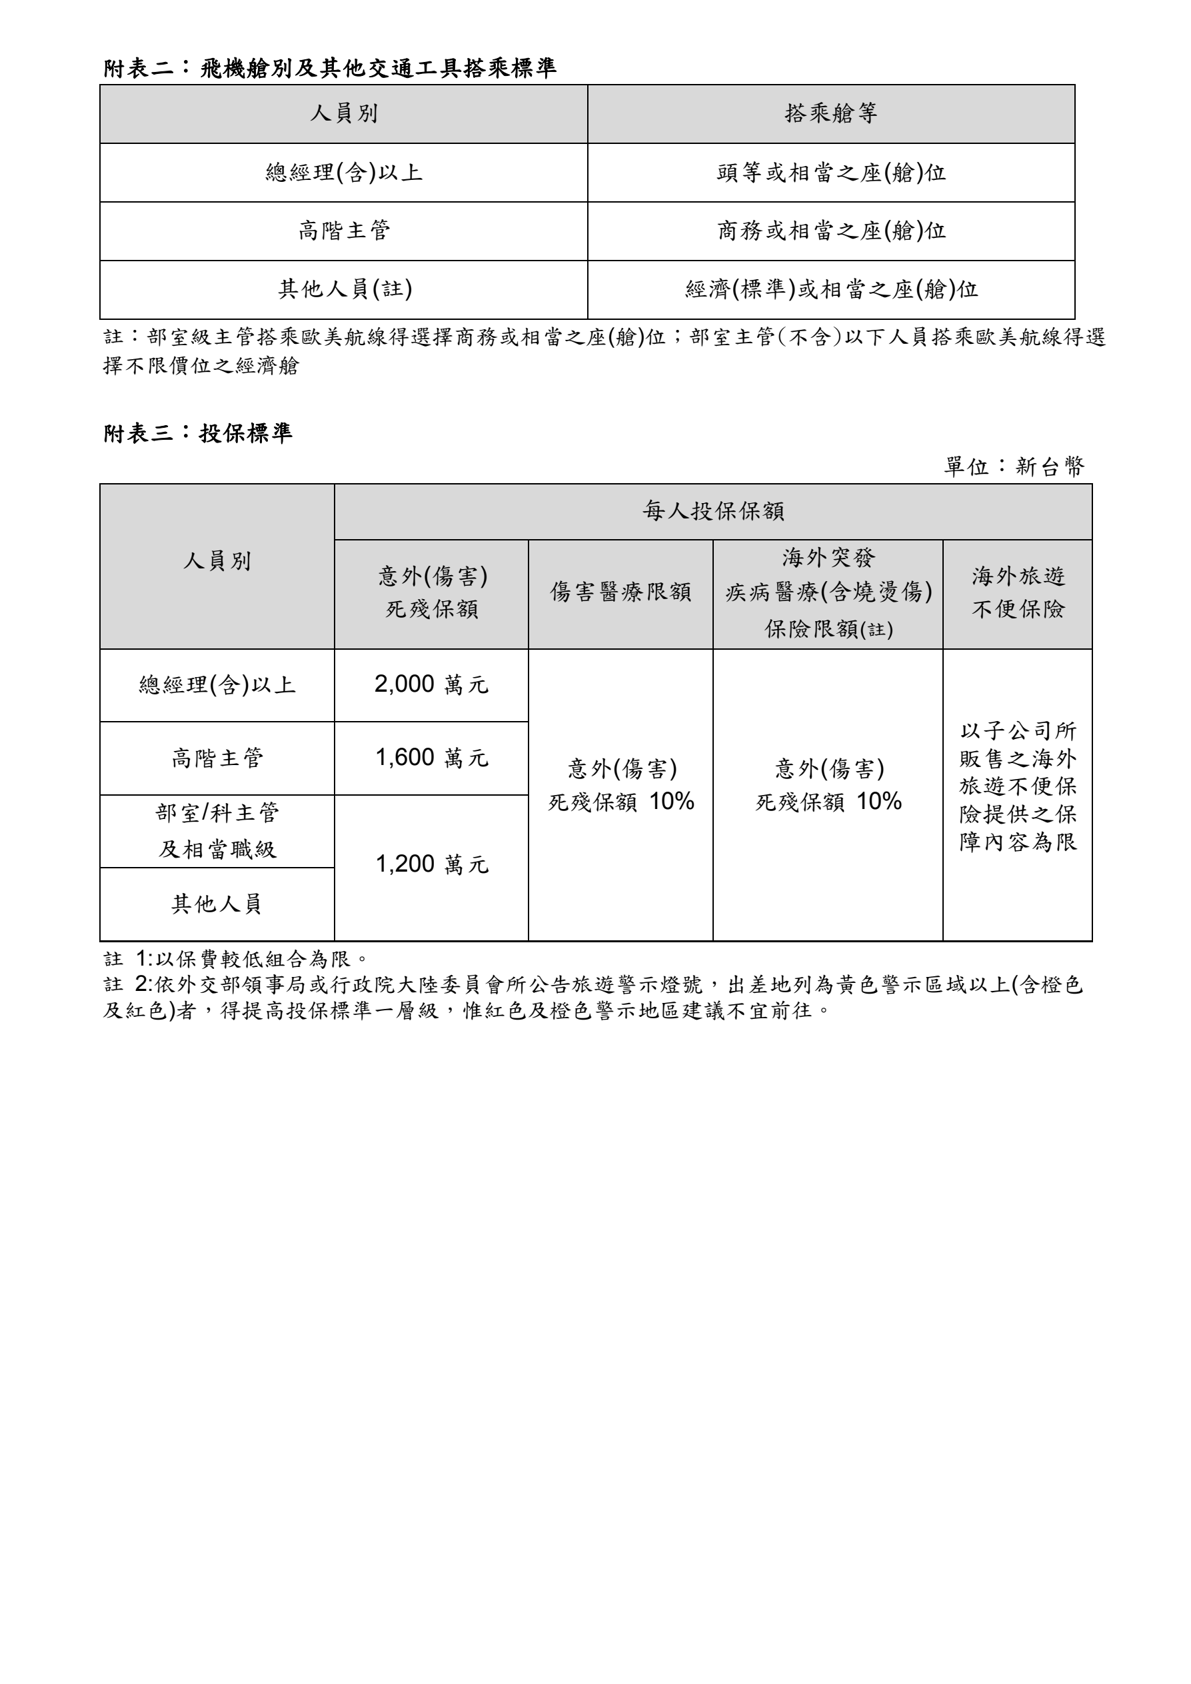
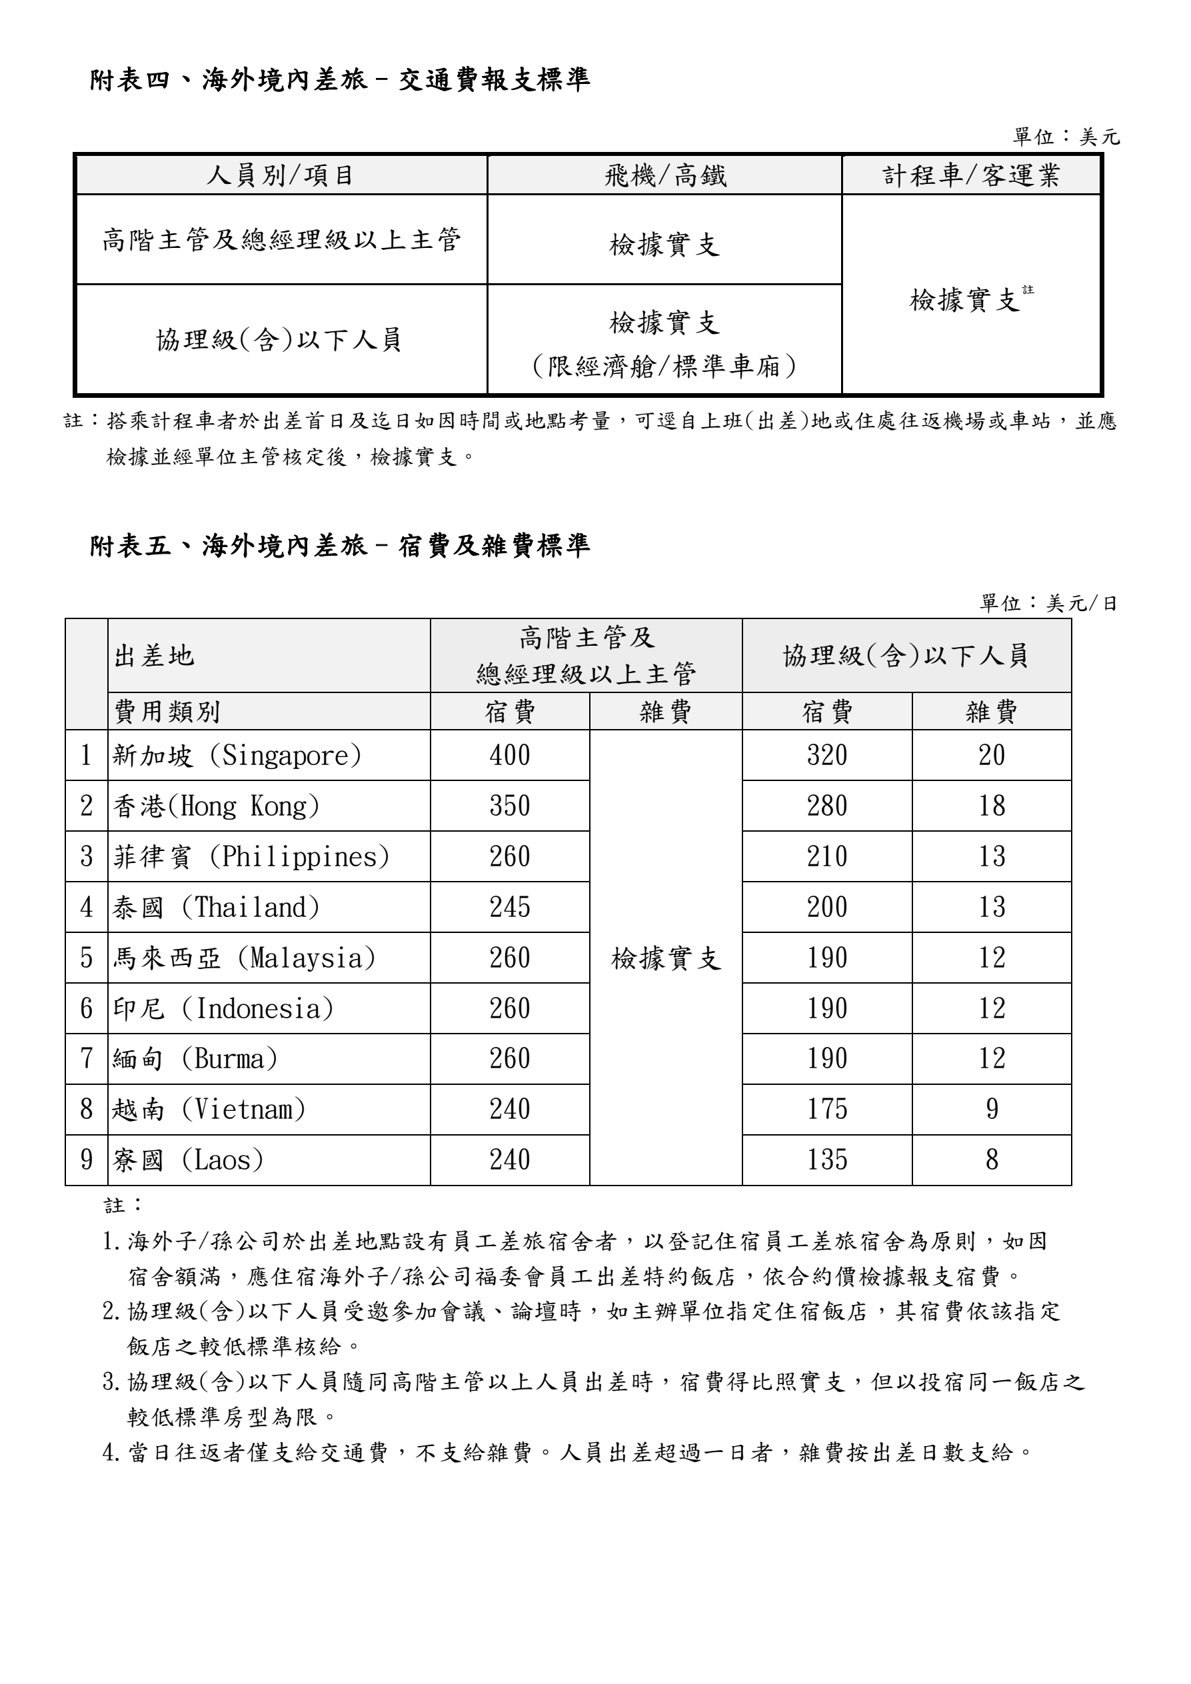

In [8]:
pp.pprint(vars(single_conv_result))

In [32]:
pp.pprint(single_conv_result.document.tables)

[TableItem(self_ref='#/tables/0', parent=RefItem(cref='#/body'), children=[], content_layer=<ContentLayer.BODY: 'body'>, label=<DocItemLabel.TABLE: 'table'>, prov=[ProvenanceItem(page_no=3, bbox=BoundingBox(l=29.8878231048584, t=781.3242797851562, r=556.8859252929688, b=27.54791259765625, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 0))], captions=[], references=[], footnotes=[], image=None, data=TableData(table_cells=[TableCell(bbox=BoundingBox(l=61.637535095214844, t=684.3228149414062, r=358.9002990722656, b=648.471435546875, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), row_span=1, col_span=1, start_row_offset_idx=0, end_row_offset_idx=1, start_col_offset_idx=0, end_col_offset_idx=1, text='名稱(地區、國家、城市或其他)', column_header=True, row_header=False, row_section=False), TableCell(bbox=BoundingBox(l=451.47174072265625, t=701.8604125976562, r=663.9944458007812, b=629.4400024414062, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), row_span=1, col_span=2, st

In [10]:
#pp.pprint(single_conv_result.document.texts)

In [11]:
#pp.pprint(single_conv_result.document.groups)

In [13]:
conv_results = pypdfium_converter.convert_all(
    doc_source,
    raises_on_error=True,  # to let conversion run through all and examine results at the end
)

all_tables = []
for result in conv_results:
    for i, table in enumerate(result.document.tables):
        table_df = table.export_to_dataframe()
        
        # 該表格無特別索引值，且與上一個處理的表格行數相同，則合併
        if all_tables and list(table_df.columns.values) == list(range(len(table_df.columns))) and len(all_tables[-1].columns) == len(table_df.columns):
            unify_columns = list(all_tables[-1].columns)
            table_df.columns = unify_columns

            table_df = pd.concat([all_tables[-1], table_df])
            all_tables.pop()

        all_tables.append(table_df) 



In [14]:
for table_ix, table in enumerate(all_tables):
    print(f"## Table {table_ix}")
    display(table)

## Table 0


0      1        2        3        4        5        6      7
0  保險年齡  30歲以下  31歲至40歲  41歲至50歲  51歲至60歲  61歲至70歲  71歲至90歲  91歲以上
1    比率   190%     160%     140%     120%     110%     102%   100%

## Table 1


項別                                                   
0  -                                        雙目均失明者（註1）。
1  二                              兩上肢腕關節缺失者或兩下肢足踝關節缺失者。
2  三                                 -上肢腕關節及-下肢足踝關節缺失者。
3  四                    -目失明及-上肢腕關節缺失者或-目失明及-下肢足踝關節缺失者。
4  五                             永久喪失咀嚼（註2）或言語（註3）之機能者。
5  六  四肢機能永久完全喪失者（註4）。  中樞神經系統機能遺存極度障害或胸、腹部臟器機能遺存極度障...

## Table 2


保險單年度 可借成數                     可借金額上限
0     第 1 年  60%  可借金額上限＝借款當日保單價值準備金 × 可借成數
1   第 2~6 年  70%  可借金額上限＝借款當日保單價值準備金 × 可借成數
2  第 7 年及以後  85%  可借金額上限＝借款當日保單價值準備金 × 可借成數

## Table 3


單件主約保額(美元)  折減比例
0  200,000~349,999  1.0%
1  350,000~499,999  1.5%
2        500,000以上  2.0%

## Table 4


國泰人壽吉美利101利率變動型  美元終身壽險(定期給付型).保單年度 男性.5歲 男性.35歲 男性.65歲 女性.5歲 女性.35歲 女性.65歲
0                                   1   38%    39%    36%   38%    39%    36%
1                                   5   65%    65%    60%   64%    65%    61%
2                                  10   92%    92%    83%   92%    92%    85%
3                                  15   96%    94%    82%   96%    96%    85%
4                                  20  100%    97%    80%  101%    99%    85%

## Table 5


保險單年度末               年齡        年繳實繳.年繳實繳 基本保險金額.保單現金值  (解約金)  \
0                1               40           47,775              26,750   
1                2               41           47,775              62,250   
2                3               42                0              63,250   
3                4               43                0              64,250   
4                5               44                0              83,000   
5                6               45                0              86,250   
6                7               46                0              87,750   
7               10               49                0              90,250   
8               20               59                0              98,250   
9  保險年齡達105歲之祝壽保險金  保險年齡達105歲之祝壽保險金  保險年齡達105歲之祝壽保險金              97,500   

  基本保險金額.身故/完全失能  保險金 基本保險金額.特定傷病  保險金 增值回饋分享金  (假設宣告利率3.85%).累計增加  保險金額  \
0              57,200           12,500                          2,617.21   
1             113,750           12,500                          8,553.71   
2             115,500           12,500                         14,629.72   
3             250,000           12,500                         20,848.52   
4             245,750           12,500                         27,213.46   
5             241,750           12,500                         33,727.98   
6             237,500           12,500                         40,395.59   
7             225,750           12,500                         61,353.37   
8             190,750           12,500                        142,764.34   
9              97,500           97,500                        338,162.10   

  增值回饋分享金  (假設宣告利率3.85%).保單現金值   (解約金) 總計  (假設宣告利率3.85%).保單現金值   (解約金)  \
0                               840.12                       27,590.12   
1                             2,779.96                       65,029.96   
2                             4,827.81                       68,077.81   
3                             6,963.41                       71,213.41   
4                             9,170.94                       92,170.94   
5                            11,467.51                       97,717.51   
6                            13,855.69                      101,605.69   
7                            21,657.74                      111,907.74   
8                            54,678.74                      152,928.74   
9                           338,162.10                      435,662.10   

  總計  (假設宣告利率3.85%).身故/完全失能  保險金  
0                      57,200.00  
1                     114,942.00  
2                     119,453.00  
3                     264,630.00  
4                     266,244.00  
5                     268,065.00  
6                     269,542.00  
7                     274,697.00  
8                     292,798.00  
9                     435,662.10

## Table 6


繳費年期  \
0                                                 躉繳   
1                                                2年期   
2  註：僅高保費折減可與他項折減合併累計計算，躉繳折減累計最高比例以1.0%  為限2年繳折減累...   

                                      單件主附約年繳化保費(美元)  \
0                                        60,000(含)以上   
1                                        40,000(含)以上   
2  註：僅高保費折減可與他項折減合併累計計算，躉繳折減累計最高比例以1.0%  為限2年繳折減累...   

                                                折減比例  
0                                               1.0%  
1                                               1.0%  
2  註：僅高保費折減可與他項折減合併累計計算，躉繳折減累計最高比例以1.0%  為限2年繳折減累...

## Table 7


國泰人壽美利雙寶利率  變動型美元終身保險  （定期給付型）.保單年度 男性，2年期.16歲 男性，2年期.35歲 男性，2年期.65歲  \
0                                   1        52%        53%        53%   
1                                   5        77%        78%        77%   
2                                  10        79%        79%        75%   
3                                  15        77%        76%        70%   
4                                  20        75%        73%        66%   

  女性，2年期.16歲 女性，2年期.35歲 女性，2年期.65歲  
0        50%        52%        53%  
1        75%        78%        77%  
2        77%        79%        76%  
3        75%        78%        72%  
4        74%        75%        67%

## Table 8


上班時間     下班時間
0     上午8時     下午5時
1  上午8時30分  下午5時30分
2     上午9時     下午6時
3  上午9時30分  下午6時30分

## Table 9


人員/項目      全日雜費       宿費  \
0      總經理以上      檢據實支     檢據實支   
1       高階主管      檢據實支     檢據實支   
2  部室主管及相當職級  每日 300 元  元核支交通費。   
3   科主管及相當職級  每日 300 元  元核支交通費。   
4       其他人員  每日 300 元  元核支交通費。   

                                                 交通費  
0                                               檢據實支  
1                                               檢據實支  
2                            1. 以飛機經濟艙、高鐵  標準車廂或自強號之  
3                        價格為上限。  2. 如自行開車者，依自  強號每公計  
4  元核支交通費。  3. 搭乘計程車往返機場  或車站者，補貼計程  車 費 用 單 程 上 ...

## Table 10


名稱(地區、國家、城市或其他). 總經理級以上主管   宿費 餐雜費.宿費  \
0                               亞洲地區                        
1                               中國大陸                 檢據實支   
2                          日本(Japan)                 檢據實支   
3                          南韓(Korea)                 檢據實支   
4                   菲律賓(Philippines)                 檢據實支   
5                       泰國(Thailand)                 檢據實支   
6                     馬來西亞(Malaysia)                 檢據實支   
7                     新加坡(Singapore)                 檢據實支   
8                      印尼(Indonesia)                 檢據實支   
9                          緬甸(Burma)                 檢據實支   
10                         印度(India)                 檢據實支   
11                     柬埔寨(Cambodia)                 檢據實支   
12                          寮國(Laos)                 檢據實支   
13                       越南(Vietnam)                 檢據實支   
14  阿拉伯聯合大公國  (United Arab Emirates)                 檢據實支   
15                       以色列(Israel)                 檢據實支   
16                       土耳其(Turkey)                 檢據實支   
17                       俄羅斯(Russia)                 檢據實支   
18                     香港(Hong Kong)                 檢據實支   
19                            亞洲其他國家                 檢據實支   
20                              美洲地區                        
21                       加拿大(Canada)                 檢據實支   
22                        美國(U.S.A.)                 檢據實支   
23                       墨西哥(Mexico)                 檢據實支   
24                        巴西(Brazil)                 檢據實支   
25                         智利(Chile)                 檢據實支   
26                    阿根廷(Argentina)                 檢據實支   
27                      烏拉圭(Uruguay)                 檢據實支   
28                            美洲其他國家                 檢據實支   
29                              歐洲地區                        
30                        法國(France)                 檢據實支   
31                       德國(Germany)                 檢據實支   
32                   荷蘭(Netherlands)                 檢據實支   
33                      比利時(Belgium)                 檢據實支   
34                   盧森堡(Luxembourg)                 檢據實支   
35                   瑞士(Switzerland)                 檢據實支   
36                       丹麥(Denmark)                 檢據實支   
0                         瑞典(Sweden)                 檢據實支   
1                 英國(United Kingdom)                 檢據實支   
2                         西班牙(Spain)                 檢據實支   
3                         義大利(Italy)                 檢據實支   
4                             歐洲其他國家                 檢據實支   
5                              大洋洲地區                        
6                    澳大利亞(Australia)                 檢據實支   
7                   紐西蘭(New Zealand)                 檢據實支   
8                            大洋洲其他國家                 檢據實支   
9                               非洲地區                        
10           南非共和國(South Africa Rep)                 檢據實支   
11                            非洲其他國家                 檢據實支   

   總經理級以上主管   宿費 餐雜費.餐雜費 高階主管.宿費 高階主管.餐雜費 協理級(含)   以下人員   宿費 餐雜費.宿費  \
0                                                                     
1               110或檢據實支     270      110                       215   
2               140或檢據實支     345      140                       275   
3               130或檢據實支     315      130                       255   
4               105或檢據實支     260      105                       210   
5               100或檢據實支     245      100                       200   
6               100或檢據實支     260      100                       190   
7               160或檢據實支     400      160                       320   
8               100或檢據實支     260      100                       190   
9               100或檢據實支     260      100                       190   
10              120或檢據實支     300      120                       240   
11               90或檢據實支     240       90                       145   
12               90或檢據實支     240       90     

## Table 11


人員別             搭乘艙等
0  總經理(含)以上      頭等或相當之座(艙)位
1      高階主管      商務或相當之座(艙)位
2   其他人員(註)  經濟(標準)或相當之座(艙)位

## Table 12


每人投保保額             每人投保保額                     每人投保保額  \
0            意外(傷害)   死殘保額             傷害醫療限額  海外突發  疾病醫療(含燒燙傷)  保險限額(註)   
1  總經理(含)以上       2,000 萬元  意外(傷害)   死殘保額 10%          意外(傷害)   死殘保額 10%   
2      高階主管       1,600 萬元  意外(傷害)   死殘保額 10%          意外(傷害)   死殘保額 10%   
3    部室/科主管        1200 萬元  意外(傷害)   死殘保額 10%          意外(傷害)   死殘保額 10%   
4     及相當職級        1200 萬元  意外(傷害)   死殘保額 10%          意外(傷害)   死殘保額 10%   
5      其他人員        1200 萬元  意外(傷害)   死殘保額 10%          意外(傷害)   死殘保額 10%   

         每人投保保額  
0    海外旅遊  不便保險  
1  販售之海外  旅遊不便保  
2  販售之海外  旅遊不便保  
3  販售之海外  旅遊不便保  
4  販售之海外  旅遊不便保  
5  販售之海外  旅遊不便保

## Table 13


0      1              2
0         人員別/項目  飛機/高鐵        計程車/客運業
1  高階主管及總經理級以上主管   檢據實支  高階主管及總經理級以上主管
2     協理級(含)以下人員   檢據實支  高階主管及總經理級以上主管

## Table 14


費.費           出差地.費用類別 高階主管及  總經理級以上主管.宿費 高階主管及  總經理級以上主管.雜費  \
0   1    新加坡 (Singapore)                400               檢據實支   
1   2      香港(Hong Kong)                350               檢據實支   
2   3  菲律賓 (Philippines)                260               檢據實支   
3   4      泰國 (Thailand)                245               檢據實支   
4   5    馬來西亞 (Malaysia)                260               檢據實支   
5   6      尼 (Indonesia)                260               檢據實支   
6   7          緬甸 (Burma                260               檢據實支   
7   8         越南 (Vietna                240               檢據實支   
8   9             (Laos)                240               檢據實支   

  協理級(含)以下人員  宿費 雜費.宿費 協理級(含)以下人員  宿費 雜費.雜費  
0                  320                   20  
1                  280                   18  
2                  210                   13  
3                  200                   13  
4                  190                   12  
5                  190                   12  
6                  190                   12  
7                  175                    9  
8                  135                    8

In [25]:
str_tables_list = []
for table_ix, table in enumerate(all_tables):
    str_table = f"## Table {table_ix}\n {table.to_markdown()}"
    str_tables_list.append(str_table)

In [ ]:
print(str_tables_list[14])

## Table 14
 |    |   費.費 | 出差地.費用類別      |   高階主管及  總經理級以上主管.宿費 | 高階主管及  總經理級以上主管.雜費   |   協理級(含)以下人員  宿費 雜費.宿費 |   協理級(含)以下人員  宿費 雜費.雜費 |
|---:|--------:|:---------------------|------------------------------------:|:------------------------------------|-------------------------------------:|-------------------------------------:|
|  0 |       1 | 新加坡 (Singapore)   |                                 400 | 檢據實支                            |                                  320 |                                   20 |
|  1 |       2 | 香港(Hong Kong)      |                                 350 | 檢據實支                            |                                  280 |                                   18 |
|  2 |       3 | 菲律賓 (Philippines) |                                 260 | 檢據實支                            |                                  210 |                                   13 |
|  3 |       4 | 泰國 (Thailand)      |                                 245 | 檢據實支                        

In [44]:
test_pd_table = all_tables[10]
test_pd_table

名稱(地區、國家、城市或其他). 總經理級以上主管   宿費 餐雜費.宿費  \
0                               亞洲地區                        
1                               中國大陸                 檢據實支   
2                          日本(Japan)                 檢據實支   
3                          南韓(Korea)                 檢據實支   
4                   菲律賓(Philippines)                 檢據實支   
5                       泰國(Thailand)                 檢據實支   
6                     馬來西亞(Malaysia)                 檢據實支   
7                     新加坡(Singapore)                 檢據實支   
8                      印尼(Indonesia)                 檢據實支   
9                          緬甸(Burma)                 檢據實支   
10                         印度(India)                 檢據實支   
11                     柬埔寨(Cambodia)                 檢據實支   
12                          寮國(Laos)                 檢據實支   
13                       越南(Vietnam)                 檢據實支   
14  阿拉伯聯合大公國  (United Arab Emirates)                 檢據實支   
15                       以色列(Israel)                 檢據實支   
16                       土耳其(Turkey)                 檢據實支   
17                       俄羅斯(Russia)                 檢據實支   
18                     香港(Hong Kong)                 檢據實支   
19                            亞洲其他國家                 檢據實支   
20                              美洲地區                        
21                       加拿大(Canada)                 檢據實支   
22                        美國(U.S.A.)                 檢據實支   
23                       墨西哥(Mexico)                 檢據實支   
24                        巴西(Brazil)                 檢據實支   
25                         智利(Chile)                 檢據實支   
26                    阿根廷(Argentina)                 檢據實支   
27                      烏拉圭(Uruguay)                 檢據實支   
28                            美洲其他國家                 檢據實支   
29                              歐洲地區                        
30                        法國(France)                 檢據實支   
31                       德國(Germany)                 檢據實支   
32                   荷蘭(Netherlands)                 檢據實支   
33                      比利時(Belgium)                 檢據實支   
34                   盧森堡(Luxembourg)                 檢據實支   
35                   瑞士(Switzerland)                 檢據實支   
36                       丹麥(Denmark)                 檢據實支   
0                         瑞典(Sweden)                 檢據實支   
1                 英國(United Kingdom)                 檢據實支   
2                         西班牙(Spain)                 檢據實支   
3                         義大利(Italy)                 檢據實支   
4                             歐洲其他國家                 檢據實支   
5                              大洋洲地區                        
6                    澳大利亞(Australia)                 檢據實支   
7                   紐西蘭(New Zealand)                 檢據實支   
8                            大洋洲其他國家                 檢據實支   
9                               非洲地區                        
10           南非共和國(South Africa Rep)                 檢據實支   
11                            非洲其他國家                 檢據實支   

   總經理級以上主管   宿費 餐雜費.餐雜費 高階主管.宿費 高階主管.餐雜費 協理級(含)   以下人員   宿費 餐雜費.宿費  \
0                                                                     
1               110或檢據實支     270      110                       215   
2               140或檢據實支     345      140                       275   
3               130或檢據實支     315      130                       255   
4               105或檢據實支     260      105                       210   
5               100或檢據實支     245      100                       200   
6               100或檢據實支     260      100                       190   
7               160或檢據實支     400      160                       320   
8               100或檢據實支     260      100                       190   
9               100或檢據實支     260      100                       190   
10              120或檢據實支     300      120                       240   
11               90或檢據實支     240       90                       145   
12               90或檢據實支     240       90     

In [45]:
test_pd_table.loc[14]

名稱(地區、國家、城市或其他).              阿拉伯聯合大公國  (United Arab Emirates)
總經理級以上主管   宿費 餐雜費.宿費                                      檢據實支
總經理級以上主管   宿費 餐雜費.餐雜費                                 160或檢據實支
高階主管.宿費                                                    395
高階主管.餐雜費                                                   160
協理級(含)   以下人員   宿費 餐雜費.宿費                                  315
協理級(含)   以下人員   宿費 餐雜費.餐雜費                                 120
Name: 14, dtype: object

In [71]:
class DataFrameFormatter:
    @staticmethod
    def format_row(series_row):
        output = []
        for key, value in series_row.items():
            if pd.notnull(value):
                output.append(f"{key} = {value}")
        return ', '.join(output)

    def format_all(self, df: pd.DataFrame):
        formatted_rows = []
        for idx, row in df.iterrows():
            formatted_row = self.format_row(row)
            formatted_rows.append(formatted_row)
        return '\n '.join(formatted_rows)
    
formatter = DataFrameFormatter()
for table in all_tables:
    result_string = formatter.format_all(table)
    print(result_string)
    print("\n")

0 = 保險年齡, 1 = 30歲以下, 2 = 31歲至40歲, 3 = 41歲至50歲, 4 = 51歲至60歲, 5 = 61歲至70歲, 6 = 71歲至90歲, 7 = 91歲以上
 0 = 比率, 1 = 190%, 2 = 160%, 3 = 140%, 4 = 120%, 5 = 110%, 6 = 102%, 7 = 100%


項別 = -,  = 雙目均失明者（註1）。
 項別 = 二,  = 兩上肢腕關節缺失者或兩下肢足踝關節缺失者。
 項別 = 三,  = -上肢腕關節及-下肢足踝關節缺失者。
 項別 = 四,  = -目失明及-上肢腕關節缺失者或-目失明及-下肢足踝關節缺失者。
 項別 = 五,  = 永久喪失咀嚼（註2）或言語（註3）之機能者。
 項別 = 六,  = 四肢機能永久完全喪失者（註4）。  中樞神經系統機能遺存極度障害或胸、腹部臟器機能遺存極度障害，終身不能從事任何工作


保險單年度 = 第 1 年, 可借成數 = 60%, 可借金額上限 = 可借金額上限＝借款當日保單價值準備金 × 可借成數
 保險單年度 = 第 2~6 年, 可借成數 = 70%, 可借金額上限 = 可借金額上限＝借款當日保單價值準備金 × 可借成數
 保險單年度 = 第 7 年及以後, 可借成數 = 85%, 可借金額上限 = 可借金額上限＝借款當日保單價值準備金 × 可借成數


單件主約保額(美元) = 200,000~349,999, 折減比例 = 1.0%
 單件主約保額(美元) = 350,000~499,999, 折減比例 = 1.5%
 單件主約保額(美元) = 500,000以上, 折減比例 = 2.0%


國泰人壽吉美利101利率變動型  美元終身壽險(定期給付型).保單年度 = 1, 男性.5歲 = 38%, 男性.35歲 = 39%, 男性.65歲 = 36%, 女性.5歲 = 38%, 女性.35歲 = 39%, 女性.65歲 = 36%
 國泰人壽吉美利101利率變動型  美元終身壽險(定期給付型).保單年度 = 5, 男性.5歲 = 65%, 男性.35歲 = 65%, 男性.65歲 = 60%, 女性.5歲 = 64%, 女性.35歲 = 65%, 女性.65歲 = 61%
 國泰人壽吉美利101利率變動型  美元

In [72]:
class DataFrameFormatter:
    def __init__(self, tokenizer, show_index=False, max_tokens=1024):
        self.tokenizer = tokenizer
        self.show_index = show_index
        self.max_tokens = max_tokens

    @staticmethod
    def format_row(series_row, row_index=None, show_index=False):
        output = []
        for key, value in series_row.items():
            if pd.notnull(value) and str(value).strip() != "":
                entry = f"{key} = {value}"
                if show_index:
                    entry += f". {row_index}"
                output.append(entry)
        return ', '.join(output)

    def format_all_rows(self, df: pd.DataFrame):
        return [
            self.format_row(row, idx + 1, self.show_index)
            for idx, row in df.iterrows()
        ]

    def chunk_rows(self, df: pd.DataFrame):
        formatted_rows = self.format_all_rows(df)
        chunks = []
        current_chunk = []
        current_tokens = 0

        for row in formatted_rows:
            row_tokens = len(self.tokenizer.tokenize(row))
            if current_tokens + row_tokens <= self.max_tokens:
                current_chunk.append(row)
                current_tokens += row_tokens
            else:
                # 儲存目前 chunk
                chunks.append('\n'.join(current_chunk))
                # 開始新的 chunk
                current_chunk = [row]
                current_tokens = row_tokens

        if current_chunk:
            chunks.append('\n'.join(current_chunk))

        return chunks

In [73]:
formatter = DataFrameFormatter(tokenizer=tokenizer, show_index=False, max_tokens=1024)

all_chunks = []
for table in all_tables:
    chunks = formatter.chunk_rows(table)
    all_chunks.extend(chunks)

# all_chunks 就是 chunked 結果

In [99]:
print(all_chunks[21])

費.費 = 1, 出差地.費用類別 = 新加坡 (Singapore), 高階主管及  總經理級以上主管.宿費 = 400, 高階主管及  總經理級以上主管.雜費 = 檢據實支, 協理級(含)以下人員  宿費 雜費.宿費 = 320, 協理級(含)以下人員  宿費 雜費.雜費 = 20
費.費 = 2, 出差地.費用類別 = 香港(Hong Kong), 高階主管及  總經理級以上主管.宿費 = 350, 高階主管及  總經理級以上主管.雜費 = 檢據實支, 協理級(含)以下人員  宿費 雜費.宿費 = 280, 協理級(含)以下人員  宿費 雜費.雜費 = 18
費.費 = 3, 出差地.費用類別 = 菲律賓 (Philippines), 高階主管及  總經理級以上主管.宿費 = 260, 高階主管及  總經理級以上主管.雜費 = 檢據實支, 協理級(含)以下人員  宿費 雜費.宿費 = 210, 協理級(含)以下人員  宿費 雜費.雜費 = 13
費.費 = 4, 出差地.費用類別 = 泰國 (Thailand), 高階主管及  總經理級以上主管.宿費 = 245, 高階主管及  總經理級以上主管.雜費 = 檢據實支, 協理級(含)以下人員  宿費 雜費.宿費 = 200, 協理級(含)以下人員  宿費 雜費.雜費 = 13
費.費 = 5, 出差地.費用類別 = 馬來西亞 (Malaysia), 高階主管及  總經理級以上主管.宿費 = 260, 高階主管及  總經理級以上主管.雜費 = 檢據實支, 協理級(含)以下人員  宿費 雜費.宿費 = 190, 協理級(含)以下人員  宿費 雜費.雜費 = 12
費.費 = 6, 出差地.費用類別 = 尼 (Indonesia), 高階主管及  總經理級以上主管.宿費 = 260, 高階主管及  總經理級以上主管.雜費 = 檢據實支, 協理級(含)以下人員  宿費 雜費.宿費 = 190, 協理級(含)以下人員  宿費 雜費.雜費 = 12
費.費 = 7, 出差地.費用類別 = 緬甸 (Burma, 高階主管及  總經理級以上主管.宿費 = 260, 高階主管及  總經理級以上主管.雜費 = 檢據實支, 協理級(含)以下人員  宿費 雜費.宿費 = 190, 協理級(含)以下人員  宿費 雜費.雜費 = 12
費.